# Sigmoid scoring on fused features, and concatenate attention output with scored fused features as input to the MLP classifier. 85.29% overall AUC

Training/testing directories already present; skipping download.
trustworthyAI already present at /content/trustworthyAI
Imported trustworthyAI utils.
Loading .npz from: dataset_extracted/Training dataset_extracted/Testing
Found .npz - train: 8000  test: 2000
Processed arrays - train: 8000  test: 2000
Glaucoma counts (train): [4434 3566]
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 150MB/s]


DAG utilities loaded.
model.pos_weight: 1.2434099912643433
Starting Stage 1 warmup for 10 epochs (HEAD_LR=0.001)
Stage1 Epoch 1/10 - train_loss 1.3502
Saved best (stage1)
Stage1 Epoch 2/10 - train_loss 1.3165
Saved best (stage1)
Stage1 Epoch 3/10 - train_loss 1.3197
Stage1 Epoch 4/10 - train_loss 1.3086
Saved best (stage1)
Stage1 Epoch 5/10 - train_loss 1.3055
Saved best (stage1)
Stage1 Epoch 6/10 - train_loss 1.3019
Saved best (stage1)
Stage1 Epoch 7/10 - train_loss 1.3019
Saved best (stage1)
Stage1 Epoch 8/10 - train_loss 1.2962
Saved best (stage1)
Stage1 Epoch 9/10 - train_loss 1.2942
Saved best (stage1)
Stage1 Epoch 10/10 - train_loss 1.2984
Starting Stage 2 joint training for 50 epochs (BACKBONE_LR=3e-05)
Stage2 Epoch 1/50 - train_loss 1.2716
Saved best (stage2)
Stage2 Epoch 2/50 - train_loss 1.2391
Saved best (stage2)
Stage2 Epoch 3/50 - train_loss 1.2268
Saved best (stage2)
Stage2 Epoch 4/50 - train_loss 1.2087
Saved best (stage2)
Stage2 Epoch 5/50 - train_loss 1.2118
Stage2 Epo

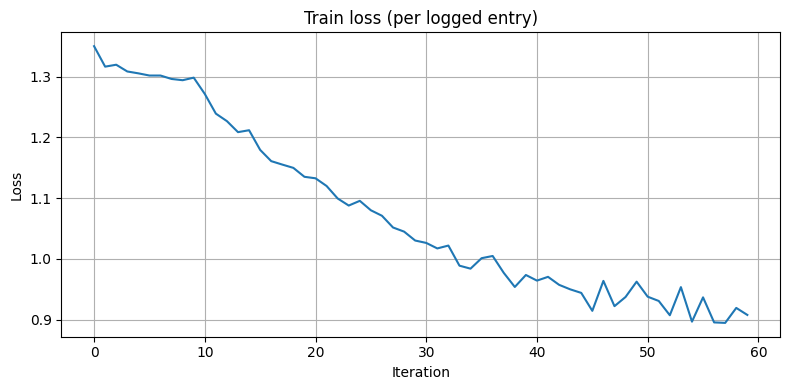

Final test metrics dict:
{'Overall': {'accuracy': 0.7625, 'f1_score': 0.7442110931610124, 'sensitivity': 0.7790304396843292, 'specificity': 0.7493261455525606, 'roc_auc': 0.8529320898553632}, 'Male': {'accuracy': 0.7586206896551724, 'f1_score': 0.7323943661971831, 'sensitivity': 0.7583333333333333, 'specificity': 0.7588424437299035, 'roc_auc': 0.8532556270096463}, 'Female': {'accuracy': 0.7639751552795031, 'f1_score': 0.7485294117647059, 'sensitivity': 0.7867078825347759, 'specificity': 0.7456359102244389, 'roc_auc': 0.8527001661225606}, 'White': {'accuracy': 0.7608409986859396, 'f1_score': 0.723404255319149, 'sensitivity': 0.7765089722675367, 'specificity': 0.7502750275027503, 'roc_auc': 0.8514384880576149}, 'Black': {'accuracy': 0.7541528239202658, 'f1_score': 0.8021390374331551, 'sensitivity': 0.78125, 'specificity': 0.7064220183486238, 'roc_auc': 0.832664373088685}, 'Asian': {'accuracy': 0.7909604519774012, 'f1_score': 0.7784431137724551, 'sensitivity': 0.7926829268292683, 'specifi

In [ ]:
# combined_max_accuracy_attempt_no_validation_metrics.py
# Modified to:
# 1. Use sigmoid scoring on fused features, and concatenate attention output
#    with scored fused features as input to the MLP classifier.
# 2. Include comprehensive metrics: Overall AUC, Accuracy, F1, Sensitivity, Specificity.
# 3. Group results by Overall, Asian, Black, White, Male, Female.

import os, sys, zipfile, glob, subprocess, copy, math, time, traceback
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt

# -------------------------
# User-editable config (tune these)
# -------------------------
GDRIVE_LINK = "Drive link to the fairdomain zip file"
FAIRDOMAIN_ZIP = "FairDomain.zip"
EXTRACT_ROOT = "dataset_extracted"
TRAIN_DIR = os.path.join(EXTRACT_ROOT, "Training")
TEST_DIR  = os.path.join(EXTRACT_ROOT, "Testing")
REPO_DIR  = "/content/trustworthyAI"
SUMMARY_CSV_PATH = "/content/data_summary.csv"  # Added for demographic lookups

# Model/training hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 24                      # reduce if OOM; use 16 if needed
NUM_EPOCHS_STAGE1 = 10
NUM_EPOCHS_STAGE2 = 50
HEAD_LR = 1e-3
BACKBONE_LR = 3e-5
WEIGHT_DECAY = 1e-5
INPUT_MEAN = 0.5
INPUT_STD  = 0.25

# Latent sizes (you asked 64x64 adjacency earlier; left here as originally set)
Z1_DIM = 64
Z2_DIM = 4
Z_DIM = Z1_DIM * Z2_DIM

# backbone/proj sizes
BACKBONE = "efficientnet_b3"   # options: efficientnet_b3, efficientnet_b0, densenet121, resnet34
PROJ_DIM = 1024

GLAUCOMA_MLP_HIDDEN = 256
MAX_GRAD_NORM = 1.0
KL_ANNEAL_EPOCHS = 8
EARLY_STOP_PATIENCE = 12

USE_MIXUP = True
MIXUP_ALPHA = 0.2
USE_SWA = True
SWA_START_EPOCH = max(1, NUM_EPOCHS_STAGE2 - 5)  # start SWA near the end
# -------------------------

def run_shell(cmd):
    print("RUN:", cmd)
    r = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if r.returncode != 0:
        print(r.stderr.decode("utf-8"))
    return r

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# download + extract FairDomain.zip and inner dataset.zip
def download_and_extract_fairdomain(gdrive_link=GDRIVE_LINK, out_zip=FAIRDOMAIN_ZIP):
    try:
        import gdown
    except Exception:
        print("Installing gdown...")
        run_shell("pip install -q gdown")
        import gdown
    # parse id
    parts = gdrive_link.split("/")
    file_id = None
    for i,p in enumerate(parts):
        if p == "d" and i+1 < len(parts):
            file_id = parts[i+1]; break
    if file_id is None:
        file_id = gdrive_link.split("/")[-2]
    print("Downloading FairDomain.zip (id=%s)..." % file_id)
    gdown.download(id=file_id, output=out_zip, quiet=False)
    if not os.path.exists(out_zip):
        raise RuntimeError("Download failed: %s" % out_zip)
    print("Extracting FairDomain.zip ...")
    with zipfile.ZipFile(out_zip, "r") as z:
        z.extractall(".")
    # find inner dataset zip
    candidates = glob.glob("**/dataset*.zip", recursive=True)
    if not candidates:
        candidates = glob.glob("**/dataset.zip", recursive=True)
    if not candidates:
        raise RuntimeError("Could not find dataset.zip inside FairDomain.zip extracted contents.")
    dataset_zip = candidates[0]
    print("Found dataset:", dataset_zip)
    os.makedirs(EXTRACT_ROOT, exist_ok=True)
    with zipfile.ZipFile(dataset_zip, "r") as z:
        z.extractall(EXTRACT_ROOT)
    print("Dataset extracted to", EXTRACT_ROOT)

def clone_trustworthyai(repo_dir=REPO_DIR):
    if not os.path.exists(repo_dir):
        print("Cloning trustworthyAI...")
        run_shell(f"git clone https://github.com/huawei-noah/trustworthyAI.git {repo_dir}")
    else:
        print("trustworthyAI already present at", repo_dir)
    sys.path.insert(0, os.path.join(repo_dir, "research", "CausalVAE", "codebase"))
    sys.path.insert(0, os.path.join(repo_dir, "research", "CausalVAE", "codebase", "models", "nns"))
    sys.path.insert(0, os.path.join(repo_dir, "research", "CausalVAE"))

def normalize_race_value(rv) -> int:
    """ Maps race inputs to integers: 0=White, 1=Black, 2=Asian, 3=Other """
    if rv is None: return 3
    try:
        if isinstance(rv, (str, bytes, bytearray)):
             s = str(rv).strip().lower()
             if 'white' in s: return 0
             if 'black' in s or 'african' in s: return 1
             if 'asian' in s: return 2
             return 3
        if np.isscalar(rv):
            if int(rv) in (0,1,2,3): return int(rv)
            return 3
        return 3
    except Exception:
        return 3

def load_summary_csv_as_map(csv_path: str) -> Dict[str, Dict[str, Any]]:
    if not os.path.exists(csv_path):
        print(f"Warning: Summary CSV not found at {csv_path}")
        return {}
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return {}

    possible_id_cols = [c for c in df.columns if c.lower() in ('id','subject_id','patient_id','filename','file','case','name')]
    chosen_id_col = possible_id_cols[0] if possible_id_cols else None

    if chosen_id_col is None: return {}

    df['_key'] = df[chosen_id_col].astype(str).str.strip()
    mapping = {}

    for _, row in df.iterrows():
        key = row['_key']
        key_clean = os.path.splitext(key)[0]
        mapping[key] = row.to_dict()
        mapping[key_clean] = row.to_dict()

    return mapping

def load_npz_dir(root_dir):
    out = {}
    if not os.path.exists(root_dir):
        print("Warning: path does not exist:", root_dir)
        return out
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.endswith(".npz"):
                p = os.path.join(root, f)
                k = os.path.splitext(f)[0]
                try:
                    data = np.load(p, allow_pickle=True)
                    out[k] = dict(data)
                except Exception as e:
                    print("Failed to load", p, e)
    return out

def process_dataset_data_to_arrays(data_dict, summary_map: Dict[str, Dict[str, Any]] = None):
    octs, slos, labels = [], [], []
    keys = sorted(data_dict.keys())
    for k in keys:
        d = data_dict[k]
        if "oct_fundus" not in d or "slo_fundus" not in d:
            continue
        o = d["oct_fundus"]; s = d["slo_fundus"]
        if o.ndim == 3 and o.shape[-1] == 1: o = np.squeeze(o, axis=-1)
        if s.ndim == 3 and s.shape[-1] == 1: s = np.squeeze(s, axis=-1)

        # Defaults
        glaucoma = float(d.get("glaucoma", 0.0))
        gender = float(d.get("gender", 0.0))
        age = float(d.get("age", 0.0))
        md = float(d.get("md", 0.0))
        race_val = d.get("race", None)

        # Override/Augment from CSV if available
        if summary_map and k in summary_map:
            entry = summary_map[k]
            if 'glaucoma' in entry and pd.notna(entry['glaucoma']):
                g_val = str(entry['glaucoma']).lower()
                glaucoma = 1.0 if g_val in ['yes', '1', 'true'] else 0.0
            if 'gender' in entry and pd.notna(entry['gender']):
                g_val = str(entry['gender']).lower()
                # Assuming 1=Female, 0=Male standard; adjust if dataset differs
                gender = 1.0 if g_val in ['female', 'f', '1'] else 0.0
            if 'race' in entry and pd.notna(entry['race']):
                race_val = entry['race']
            if 'age' in entry and pd.notna(entry['age']):
                try: age = float(entry['age'])
                except: pass
            if 'md' in entry and pd.notna(entry['md']):
                try: md = float(entry['md'])
                except: pass

        race_code = normalize_race_value(race_val)

        octs.append(o.astype(np.float32)); slos.append(s.astype(np.float32))
        labels.append([glaucoma, gender, age, md, float(race_code)])

    if len(octs) == 0: return np.array([]), np.array([]), np.array([])
    return np.array(octs), np.array(slos), np.array(labels, dtype=np.float32)

class DualImageDataset(Dataset):
    def __init__(self, oct_images, slo_images, labels, transform=None):
        assert len(oct_images) == len(slo_images) == len(labels)
        self.oct_images = oct_images; self.slo_images = slo_images; self.labels = labels; self.transform = transform
    def _to_pil(self,a):
        arr = a
        if arr.dtype != np.uint8:
            if arr.max() <= 1.0:
                arr = (arr*255.0).astype(np.uint8)
            elif arr.max() <= 255.0 and arr.min() >= 0:
                arr = arr.astype(np.uint8)
            else:
                amin = float(arr.min()); amax = float(arr.max())
                if amax-amin > 1e-8:
                    arr = ((arr-amin)/(amax-amin)*255.0).astype(np.uint8)
                else:
                    arr = np.zeros_like(arr, dtype=np.uint8)
        return Image.fromarray(arr)
    def __len__(self): return len(self.oct_images)
    def __getitem__(self, idx):
        o = self.oct_images[idx]; s = self.slo_images[idx]
        o_pil = self._to_pil(o); s_pil = self._to_pil(s)
        if self.transform:
            o_t = self.transform(o_pil); s_t = self.transform(s_pil)
        else:
            o_t = transforms.ToTensor()(o_pil); s_t = transforms.ToTensor()(s_pil)
        lbl = torch.tensor(self.labels[idx], dtype=torch.float32)
        return o_t, s_t, lbl

# -------------------------
# Model building blocks (kept from your file)
# -------------------------
def gaussian_parameters(h, dim=-1):
    m, v = torch.split(h, h.size(dim)//2, dim=dim)
    v = F.softplus(v) + 1e-8
    return m, v

def build_backbone(backbone='efficientnet_b3', pretrained=True):
    b = backbone.lower()
    if "efficientnet_b3" in b:
        try:
            from torchvision.models import EfficientNet_B3_Weights
            weights = EfficientNet_B3_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.efficientnet_b3(weights=weights)
        except Exception:
            net = models.efficientnet_b3(pretrained=bool(pretrained))
        try:
            feat_dim = net.classifier[1].in_features
        except Exception:
            feat_dim = 1536
        features_extractor = net.features
        return net, feat_dim, features_extractor
    elif "efficientnet_b0" in b:
        try:
            from torchvision.models import EfficientNet_B0_Weights
            weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.efficientnet_b0(weights=weights)
        except Exception:
            net = models.efficientnet_b0(pretrained=bool(pretrained))
        try:
            feat_dim = net.classifier[1].in_features
        except Exception:
            feat_dim = 1280
        features_extractor = net.features
        return net, feat_dim, features_extractor
    elif "densenet121" in b:
        try:
            from torchvision.models import DenseNet121_Weights
            weights = DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.densenet121(weights=weights)
        except Exception:
            net = models.densenet121(pretrained=bool(pretrained))
        feat_dim = 1024
        features_extractor = nn.Sequential(net.features, nn.ReLU(inplace=True))
        return net, feat_dim, features_extractor
    else:
        try:
            from torchvision.models import ResNet34_Weights
            weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.resnet34(weights=weights)
        except Exception:
            net = models.resnet34(pretrained=bool(pretrained))
        feat_dim = 512
        features_extractor = nn.Sequential(*list(net.children())[:-2])
        return net, feat_dim, features_extractor

class SingleEncoderGeneric(nn.Module):
    def __init__(self, backbone='efficientnet_b3', pretrained=True):
        super().__init__()
        net, feat_dim, extractor = build_backbone(backbone=backbone, pretrained=pretrained)
        self.backbone_name = backbone.lower()
        if hasattr(net, 'features') and self.backbone_name.startswith('efficientnet'):
            try:
                first_block = net.features[0]
                replaced = False
                for i,m in enumerate(first_block):
                    if isinstance(m, nn.Conv2d):
                        old_conv = m
                        new_conv = nn.Conv2d(1, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                                             stride=old_conv.stride, padding=old_conv.padding, bias=(old_conv.bias is not None))
                        try:
                            with torch.no_grad():
                                old_w = old_conv.weight.data
                                new_w = old_w.mean(dim=1, keepdim=True)
                                new_conv.weight.copy_(new_w)
                        except Exception:
                            pass
                        first_block[i] = new_conv
                        replaced = True
                        break
                if not replaced:
                    old_conv = net.features[0][0]
                    new_conv = nn.Conv2d(1, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                                         stride=old_conv.stride, padding=old_conv.padding, bias=(old_conv.bias is not None))
                    try:
                        with torch.no_grad():
                            old_w = old_conv.weight.data
                            new_w = old_w.mean(dim=1, keepdim=True)
                            new_conv.weight.copy_(new_w)
                    except Exception:
                        pass
                    net.features[0][0] = new_conv
            except Exception:
                pass
            self.backbone = net.features
        elif hasattr(net, 'features') and self.backbone_name.startswith('densenet'):
            try:
                old_conv = net.features.conv0
                new_conv = nn.Conv2d(1, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                                     stride=old_conv.stride, padding=old_conv.padding, bias=(old_conv.bias is not None))
                try:
                    with torch.no_grad():
                        old_w = old_conv.weight.data
                        new_w = old_w.mean(dim=1, keepdim=True)
                        new_conv.weight.copy_(new_w)
                except Exception:
                    pass
                net.features.conv0 = new_conv
            except Exception:
                pass
            self.backbone = nn.Sequential(net.features, nn.ReLU(inplace=True))
        else:
            try:
                old_conv = net.conv1
                new_conv = nn.Conv2d(1, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                                     stride=old_conv.stride, padding=old_conv.padding, bias=(old_conv.bias is not None))
                try:
                    with torch.no_grad():
                        old_w = old_conv.weight.data
                        new_w = old_w.mean(dim=1, keepdim=True)
                        new_conv.weight.copy_(new_w)
                except Exception:
                    pass
                net.conv1 = new_conv
            except Exception:
                pass
            self.backbone = extractor
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.feat_dim = feat_dim

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(1)
        f = self.backbone(x)
        if f.dim() == 4:
            f = self.pool(f).view(f.size(0), -1)
        elif f.dim() == 2:
            pass
        else:
            f = f.view(f.size(0), -1)
        return f

class DualSeparateEncoders(nn.Module):
    def __init__(self, z_dim:int, z1_dim:int, z2_dim:int, backbone='efficientnet_b3', pretrained=True, proj_dim=PROJ_DIM):
        super().__init__()
        self.z_dim = z_dim; self.z1_dim = z1_dim; self.z2_dim = z2_dim
        self.enc_o = SingleEncoderGeneric(backbone=backbone, pretrained=pretrained)
        self.enc_s = SingleEncoderGeneric(backbone=backbone, pretrained=pretrained)
        feat_dim = self.enc_o.feat_dim
        self.proj_dim = proj_dim
        self.proj_o = nn.Sequential(nn.Linear(feat_dim, proj_dim), nn.ReLU())
        self.proj_s = nn.Sequential(nn.Linear(feat_dim, proj_dim), nn.ReLU())
        self.gate = nn.Sequential(
            nn.Linear(proj_dim*2, proj_dim//2),
            nn.ReLU(),
            nn.Linear(proj_dim//2, proj_dim),
            nn.Sigmoid()
        )
        self.fusion_out = nn.Sequential(
            nn.Linear(proj_dim, 1024), nn.ReLU(), nn.Dropout(0.2), nn.Linear(1024, 2*z_dim)
        )
    def encode(self, oct_img, slo_img) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        fo = self.enc_o(oct_img); fs = self.enc_s(slo_img)
        fo_p = self.proj_o(fo); fs_p = self.proj_s(fs)
        g_in = torch.cat([fo_p, fs_p], dim=1)
        gate = self.gate(g_in)
        fused = gate * fo_p + (1.0 - gate) * fs_p
        h = self.fusion_out(fused)
        m, v = gaussian_parameters(h, dim=1)
        return m, v, fused

class GlaucomaPredictorMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=GLAUCOMA_MLP_HIDDEN, dropout=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, max(8, hidden_dim//2)),
            nn.BatchNorm1d(max(8, hidden_dim//2)),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Linear(max(8, hidden_dim//2), 1)
        )
    def forward(self,x): return self.net(x)

class SimpleDecoder(nn.Module):
    def __init__(self, z_dim, img_size=(96,96), channel=1):
        super().__init__()
        self.z_dim = z_dim; self.img_size = img_size; self.channel = channel
        self.output_dim = self.channel * self.img_size[0] * self.img_size[1]
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ELU(),
            nn.Linear(512, 1024),
            nn.ELU(),
            nn.Linear(1024, self.output_dim)
        )
    def forward(self,z):
        return self.net(z)

def focal_bce_logits(logits, targets, alpha=0.6, gamma=2.0):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    p = torch.sigmoid(logits)
    pt = p * targets + (1 - p) * (1 - targets)
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    loss = alpha_t * ((1 - pt) ** gamma) * bce
    return loss.mean()

class CausalVAE_AttnScoring_Improved(nn.Module):
    def __init__(self, ut_module=None, z1_dim=Z1_DIM, z2_dim=Z2_DIM, proj_dim=PROJ_DIM, device=DEVICE, backbone=BACKBONE):
        super().__init__()
        self.ut = ut_module
        self.z1_dim = z1_dim; self.z2_dim = z2_dim; self.z_dim = z1_dim * z2_dim
        self.proj_dim = proj_dim; self.device = device
        self.enc = DualSeparateEncoders(z_dim=self.z_dim, z1_dim=self.z1_dim, z2_dim=self.z2_dim,
                                        backbone=backbone, pretrained=True, proj_dim=self.proj_dim)
        self.decoder = SimpleDecoder(self.z_dim, img_size=(96,96), channel=1)
        try:
            from mask import DagLayer, Attention, MaskLayer
            self.dag = DagLayer(self.z1_dim, self.z1_dim, i=False, initial=True)
            self.attn_util = Attention(self.z2_dim)
            self.mask_z = MaskLayer(self.z_dim, concept=self.z1_dim, z2_dim=self.z2_dim)
            self.mask_u = MaskLayer(self.z1_dim, concept=self.z1_dim, z2_dim=1)
            print("DAG utilities loaded.")
        except Exception:
            self.dag = None; self.attn_util = None; self.mask_z = None; self.mask_u = None
        self.adj_to_feat = nn.Sequential(
            nn.Linear(self.z1_dim * self.z1_dim, max(512, self.proj_dim//2)),
            nn.ReLU(),
            nn.Linear(max(512, self.proj_dim//2), self.proj_dim)
        )
        # sigmoid scoring instead of softmax
        self.sigmoid = nn.Sigmoid()
        # classifier input now will be (proj_dim scored fused) + flattened attention (z_dim)
        self.glaucoma_predictor = GlaucomaPredictorMLP(input_dim=(self.proj_dim + self.z_dim), hidden_dim=GLAUCOMA_MLP_HIDDEN)
        self.pos_weight = None

    def compute_adjacency_from_latent(self, q_m_reshaped: torch.Tensor):
        x = q_m_reshaped.mean(dim=2)
        x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-6)
        adj = x.unsqueeze(2) * x.unsqueeze(1)
        return adj

    def negative_elbo_bound(self, oct_img, slo_img, concept_labels, sample=False, lambdav=1e-3, kl_weight=1.0):
        device = self.device
        oct_img = oct_img.to(device); slo_img = slo_img.to(device); labels = concept_labels.to(device)
        q_m, q_v, fused = self.enc.encode(oct_img, slo_img)
        batch = q_m.size(0)
        try:
            q_m_reshaped = q_m.view(batch, self.z1_dim, self.z2_dim)
        except Exception:
            q_m_reshaped = q_m.contiguous().reshape(batch, self.z1_dim, self.z2_dim)
        q_v_effective = torch.ones_like(q_m_reshaped, device=device)

        if self.dag is not None:
            try:
                decode_m, _ = self.dag.calculate_dag(q_m_reshaped, q_v_effective)
                adj_logits = None
                if hasattr(self.dag, "A") and getattr(self.dag, "A") is not None:
                    A = getattr(self.dag, "A")
                    if isinstance(A, torch.Tensor):
                        adj_logits = A.unsqueeze(0).expand(batch, -1, -1)
                if adj_logits is None:
                    adj_logits = self.compute_adjacency_from_latent(decode_m)
            except Exception:
                adj_logits = self.compute_adjacency_from_latent(q_m_reshaped)
        else:
            adj_logits = self.compute_adjacency_from_latent(q_m_reshaped)

        adj_flat = adj_logits.view(batch, -1)
        feat_logits = self.adj_to_feat(adj_flat)

        # ---------- sigmoid scoring on feat_logits and score fused features ----------
        scoring = self.sigmoid(feat_logits)             # (B, proj_dim)  values in (0,1)
        fused_scored = fused * scoring                 # elementwise
        # ---------------------------------------------------------------------------

        # ---------- compute attention e_tilde (B, z1, z2) and flatten ----------
        e_tilde = torch.zeros_like(q_m_reshaped)
        if self.attn_util is not None:
            try:
                e_tilde = self.attn_util.attention(q_m_reshaped, q_m_reshaped)[0]
            except Exception:
                e_tilde = torch.zeros_like(q_m_reshaped)
        e_flat = e_tilde.view(batch, -1)               # (B, z_dim)
        # ------------------------------------------------------------------------

        # ---------- build classifier input: concat scored fused and flattened attention ----------
        classifier_input = torch.cat([fused_scored, e_flat], dim=1)   # (B, proj_dim + z_dim)
        # ensure dtype matches classifier parameters (defensive)
        try:
            first_clf_param = next(self.glaucoma_predictor.parameters())
            clf_dtype = first_clf_param.dtype
        except StopIteration:
            clf_dtype = classifier_input.dtype
        if classifier_input.dtype != clf_dtype:
            classifier_input = classifier_input.to(clf_dtype)
        glaucoma_logits = self.glaucoma_predictor(classifier_input)
        # ----------------------------------------------------------------------------------

        # remaining VAE pieces (decoder, sampling) - unchanged
        decode_m = q_m_reshaped.clone()
        f_z1 = decode_m + e_tilde
        if sample:
            z_given_dag = f_z1
        else:
            z_given_dag = f_z1 + torch.sqrt(q_v_effective * lambdav) * torch.randn_like(f_z1).to(device)

        z_for_decoder = z_given_dag.view(batch, -1)
        decoded_flat = self.decoder(z_for_decoder)
        decoded = decoded_flat.view(batch, 1, 96, 96)

        oct_in = oct_img.unsqueeze(1) if oct_img.dim()==3 else oct_img
        resized = F.interpolate(oct_in, size=(96,96), mode="bilinear", align_corners=False)
        targets = (resized * INPUT_STD) + INPUT_MEAN
        targets = targets.clamp(0.0,1.0)

        rec_loss = F.binary_cross_entropy_with_logits(decoded, targets, reduction="mean")

        kl = torch.zeros(1, device=device)
        try:
            if self.ut is not None:
                p_m = torch.zeros_like(q_m_reshaped); p_v = torch.ones_like(q_m_reshaped)
                kl = 0.3 * self.ut.kl_normal(q_m_reshaped.view(-1, self.z_dim).to(device),
                                             q_v_effective.view(-1, self.z_dim).to(device),
                                             p_m.view(-1, self.z_dim).to(device),
                                             p_v.view(-1, self.z_dim).to(device))
                try:
                    cp_m, _ = self.ut.condition_prior(np.array([[20,15],[2,2],[59.5,26.5],[10.5,4.5]]), labels, self.z2_dim)
                    cp_v_for_kl = torch.ones([batch, self.z1_dim, self.z2_dim]).to(device)
                    for i in range(self.z1_dim):
                        kl = kl + self.ut.kl_normal(decode_m[:,i,:].to(device), cp_v_for_kl[:,i,:].to(device), cp_m[:,i,:].to(device), cp_v_for_kl[:,i,:].to(device))
                    kl = torch.mean(kl)
                except Exception:
                    kl = torch.mean(kl)
        except Exception:
            kl = torch.zeros(1, device=device)

        glaucoma_label = labels[:,0].view(-1,1).to(device)
        try:
            glaucoma_loss = focal_bce_logits(glaucoma_logits, glaucoma_label, alpha=0.6, gamma=2.0)
        except Exception:
            glaucoma_loss = F.binary_cross_entropy_with_logits(glaucoma_logits, glaucoma_label)

        nelbo = rec_loss + kl_weight * kl + glaucoma_loss

        decoded_reshaped = decoded.squeeze(1)
        # Return tuple: keep legacy outputs plus new classifier-relevant tensors
        # (nelbo, kl, rec, decoded_reshaped, z_given_dag, glaucoma_loss, fused, scoring, fused_scored, e_flat)
        return nelbo, kl, rec_loss, decoded_reshaped, z_given_dag, glaucoma_loss, fused, scoring, fused_scored, e_flat

    def loss(self, oct_img, slo_img, concept_labels, kl_weight=1.0):
        out = self.negative_elbo_bound(oct_img, slo_img, concept_labels, kl_weight=kl_weight)
        nelbo, kl, rec, _, _, glaucoma_loss = out[0], out[1], out[2], out[3], out[4], out[5]
        return nelbo, {'gen/kl':kl, 'gen/rec':rec, 'gen/glaucoma_loss':glaucoma_loss}

def mixup_data(x1, x2, y, alpha=0.2, device=DEVICE):
    if alpha <= 0:
        return x1, x2, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x1.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x1 = lam * x1 + (1 - lam) * x1[index, :]
    mixed_x2 = lam * x2 + (1 - lam) * x2[index, :]
    y_a, y_b = y, y[index]
    return mixed_x1, mixed_x2, y_a, y_b, index, lam

def evaluate_with_demographics(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs, all_labels, all_genders, all_races = [], [], [], []
    with torch.no_grad():
        for oct_img, slo_img, lbls in dataloader:
            oct_img = oct_img.to(device); slo_img = slo_img.to(device); lbls = lbls.to(device)
            glaucoma_label_true = lbls[:,0].view(-1).cpu().numpy()
            genders = lbls[:,1].view(-1).cpu().numpy()
            races   = lbls[:,4].view(-1).cpu().numpy() # Race is at index 4

            out = model.negative_elbo_bound(oct_img, slo_img, lbls, sample=True)
            # out indices: 0 nelbo,1 kl,2 rec,3 decoded,4 z_given,5 glaucoma_loss,6 fused,7 scoring,8 fused_scored,9 e_flat
            fused_scored = out[8]
            e_flat = out[9]

            classifier_input = torch.cat([fused_scored, e_flat], dim=1)
            try:
                first_clf_param = next(model.glaucoma_predictor.parameters())
                clf_dtype = first_clf_param.dtype
            except StopIteration:
                clf_dtype = classifier_input.dtype
            if classifier_input.dtype != clf_dtype:
                classifier_input = classifier_input.to(clf_dtype)

            logits = model.glaucoma_predictor(classifier_input)
            probs = torch.sigmoid(logits).view(-1).cpu().numpy()
            all_probs.append(probs); all_labels.append(glaucoma_label_true)
            all_genders.append(genders); all_races.append(races)

    if len(all_probs) == 0:
        return {}, np.array([]), np.array([]), np.array([])
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels).astype(int)
    all_genders = np.concatenate(all_genders).astype(int)
    all_races = np.concatenate(all_races).astype(int)

    def compute_metrics(y_true, y_probs):
        if len(y_true) == 0:
            return {'accuracy':np.nan, 'f1_score':np.nan, 'roc_auc':np.nan, 'sensitivity':np.nan, 'specificity':np.nan}
        preds = (y_probs > threshold).astype(int)
        m = {}
        m['accuracy'] = float(accuracy_score(y_true, preds))
        m['f1_score'] = float(f1_score(y_true, preds, zero_division=0))
        # Sensitivity (Recall)
        m['sensitivity'] = float(recall_score(y_true, preds, zero_division=0))
        # Specificity
        tn, fp, fn, tp = confusion_matrix(y_true, preds, labels=[0,1]).ravel()
        m['specificity'] = float(tn / (tn + fp)) if (tn + fp) > 0 else 0.0
        # AUC
        if len(np.unique(y_true)) > 1:
            m['roc_auc'] = float(roc_auc_score(y_true, y_probs))
        else:
            m['roc_auc'] = np.nan
        return m

    # Calculate metrics for groups
    results = {}
    results['Overall'] = compute_metrics(all_labels, all_probs)

    # Gender Groups
    results['Male'] = compute_metrics(all_labels[all_genders == 0], all_probs[all_genders == 0])
    results['Female'] = compute_metrics(all_labels[all_genders == 1], all_probs[all_genders == 1])

    # Race Groups (0=White, 1=Black, 2=Asian)
    results['White'] = compute_metrics(all_labels[all_races == 0], all_probs[all_races == 0])
    results['Black'] = compute_metrics(all_labels[all_races == 1], all_probs[all_races == 1])
    results['Asian'] = compute_metrics(all_labels[all_races == 2], all_probs[all_races == 2])

    return results, all_labels, all_probs, all_genders

# -------------------------
# Training loop without validation
# -------------------------
def train_full():
    # ensure dataset present
    if not (os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR)):
        download_and_extract_fairdomain()
    else:
        print("Training/testing directories already present; skipping download.")
    clone_trustworthyai()

    try:
        import utils as ut
        print("Imported trustworthyAI utils.")
    except Exception:
        ut = None
        print("Could not import trustworthyAI utils; continuing with fallbacks.")

    # Load summary CSV for demographics
    summary_map = load_summary_csv_as_map(SUMMARY_CSV_PATH)

    print("Loading .npz from:", TRAIN_DIR, TEST_DIR)
    training_data = load_npz_dir(TRAIN_DIR)
    testing_data = load_npz_dir(TEST_DIR)
    print("Found .npz - train:", len(training_data), " test:", len(testing_data))

    # Process data with summary map to get race/gender correctly
    oct_train_arr, slo_train_arr, labels_train_arr = process_dataset_data_to_arrays(training_data, summary_map)
    oct_test_arr, slo_test_arr, labels_test_arr = process_dataset_data_to_arrays(testing_data, summary_map)
    print("Processed arrays - train:", len(oct_train_arr), " test:", len(oct_test_arr))

    if len(oct_train_arr) == 0:
        raise RuntimeError("No training data; check extraction.")

    # input size: efficientnet_b3 expects 300, else use 224
    input_size = 300 if "efficientnet_b3" in BACKBONE else 224

    try:
        randaug = transforms.RandAugment(num_ops=2, magnitude=9)
    except Exception:
        randaug = None

    train_transform = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(input_size, scale=(0.85,1.0)),
        randaug if randaug is not None else transforms.Identity(),
        transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.06),
        transforms.ToTensor(),
        transforms.Normalize(mean=[INPUT_MEAN], std=[INPUT_STD])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[INPUT_MEAN], std=[INPUT_STD])
    ])

    # Use full provided training set (no validation split)
    train_ds = DualImageDataset(oct_train_arr, slo_train_arr, labels_train_arr, transform=train_transform)
    test_ds = DualImageDataset(oct_test_arr, slo_test_arr, labels_test_arr, transform=test_transform)

    glaucoma_labels = labels_train_arr[:,0]
    class_counts = np.array([np.sum(glaucoma_labels==0), np.sum(glaucoma_labels==1)])
    print("Glaucoma counts (train):", class_counts)
    inv_freq = 1.0 / (class_counts + 1e-8)
    sample_weights = np.array([inv_freq[int(l)] for l in glaucoma_labels])
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(), num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    model = CausalVAE_AttnScoring_Improved(ut_module=ut, z1_dim=Z1_DIM, z2_dim=Z2_DIM, proj_dim=PROJ_DIM, device=DEVICE, backbone=BACKBONE)
    model.to(DEVICE)

    def compute_pos_weight(arr):
        a = arr if isinstance(arr, np.ndarray) else arr.cpu().numpy()
        glaucoma = a[:,0] if a.size>0 else np.array([])
        if glaucoma.size == 0: return 1.0
        pos = (glaucoma==1).sum(); neg = (glaucoma==0).sum()
        if pos == 0: return 1.0
        return float(neg) / (float(pos) + 1e-8)
    model.pos_weight = torch.tensor(compute_pos_weight(labels_train_arr)).float().to(DEVICE)
    print("model.pos_weight:", float(model.pos_weight))

    # Stage1: freeze most params; unfreeze projection/gate/fusion_out, adj mapping, classifier
    for p in model.parameters(): p.requires_grad = False
    try:
        for p in model.enc.proj_o.parameters(): p.requires_grad = True
        for p in model.enc.proj_s.parameters(): p.requires_grad = True
        for p in model.enc.gate.parameters(): p.requires_grad = True
        for p in model.enc.fusion_out.parameters(): p.requires_grad = True
    except Exception:
        pass
    for p in model.adj_to_feat.parameters(): p.requires_grad = True
    for p in model.glaucoma_predictor.parameters(): p.requires_grad = True

    params_stage1 = [p for p in model.parameters() if p.requires_grad]
    opt1 = optim.AdamW(params_stage1, lr=HEAD_LR, weight_decay=WEIGHT_DECAY)
    sched1 = torch.optim.lr_scheduler.CosineAnnealingLR(opt1, T_max=max(1,NUM_EPOCHS_STAGE1), eta_min=1e-6)
    scaler = torch.amp.GradScaler()

    best_train_loss = float('inf')
    best_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss": []}

    def train_one_epoch(loader, optimizer, epoch_idx):
        model.train()
        running_loss = 0.0; n_batches = 0
        for oct_img, slo_img, lbls in loader:
            oct_img = oct_img.to(DEVICE); slo_img = slo_img.to(DEVICE); lbls = lbls.to(DEVICE)
            optimizer.zero_grad()
            if USE_MIXUP:
                mx1, mx2, ya, yb, index, lam = mixup_data(oct_img, slo_img, lbls, alpha=MIXUP_ALPHA, device=DEVICE)
                with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    # negative_elbo_bound now returns 10 items
                    nelbo, kl, rec, dec, z_given, glaucoma_loss, fused, scoring, fused_scored, e_flat = model.negative_elbo_bound(mx1, mx2, ya, kl_weight = min(1.0, epoch_idx/max(1,KL_ANNEAL_EPOCHS)))
                # build classifier input for mixup case same as in model
                classifier_input = torch.cat([fused_scored, e_flat], dim=1)
                try:
                    first_clf_param = next(model.glaucoma_predictor.parameters())
                    clf_dtype = first_clf_param.dtype
                except StopIteration:
                    clf_dtype = classifier_input.dtype
                if classifier_input.dtype != clf_dtype:
                    classifier_input = classifier_input.to(clf_dtype)
                logits = model.glaucoma_predictor(classifier_input)
                target_a = ya[:,0].view(-1,1)
                target_b = yb[:,0].view(-1,1)
                loss_a = F.binary_cross_entropy_with_logits(logits, target_a, reduction='mean')
                loss_b = F.binary_cross_entropy_with_logits(logits, target_b, reduction='mean')
                glaucoma_loss_mixed = lam * loss_a + (1-lam) * loss_b
                loss = rec + kl + glaucoma_loss_mixed
            else:
                with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    loss, sums = model.loss(oct_img, slo_img, lbls, kl_weight = min(1.0, epoch_idx/max(1,KL_ANNEAL_EPOCHS)))
            if not torch.isfinite(loss): continue
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer); scaler.update()
            loss_value = loss.detach().cpu().item()
            running_loss += loss_value; n_batches += 1
        return running_loss / (n_batches + 1e-8)

    print("Starting Stage 1 warmup for %d epochs (HEAD_LR=%g)" % (NUM_EPOCHS_STAGE1, HEAD_LR))
    for e in range(1, NUM_EPOCHS_STAGE1+1):
        tloss = train_one_epoch(train_loader, opt1, e)
        try: sched1.step()
        except Exception: pass
        history['train_loss'].append(tloss)
        print(f"Stage1 Epoch {e}/{NUM_EPOCHS_STAGE1} - train_loss {tloss:.4f}")
        if tloss < best_train_loss:
            best_train_loss = tloss; best_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict':best_wts}, "best_model_stage1.pt")
            print("Saved best (stage1)")

    for p in model.parameters(): p.requires_grad = True

    head_params = list(model.adj_to_feat.parameters()) + list(model.glaucoma_predictor.parameters())
    try:
        head_params += list(model.enc.fusion_out.parameters())
    except Exception:
        pass
    head_param_set = set(head_params)
    head_group = [p for p in model.parameters() if p in head_param_set]
    other_group = [p for p in model.parameters() if p not in head_param_set]

    opt2 = optim.AdamW([{'params': head_group, 'lr': HEAD_LR}, {'params': other_group, 'lr': BACKBONE_LR}], weight_decay=WEIGHT_DECAY)

    try:
        steps_per_epoch = max(1, len(train_loader))
        total_steps = max(1, NUM_EPOCHS_STAGE2 * steps_per_epoch)
        sched2 = torch.optim.lr_scheduler.OneCycleLR(opt2, max_lr=HEAD_LR, total_steps=total_steps)
        use_batch_sched = True
    except Exception:
        sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, T_max=max(1,NUM_EPOCHS_STAGE2), eta_min=1e-6)
        use_batch_sched = False

    swa_model = None; swa_scheduler = None
    if USE_SWA:
        try:
            from torch.optim.swa_utils import AveragedModel, SWALR
            swa_model = AveragedModel(model)
            swa_scheduler = SWALR(opt2, swa_lr=1e-4)
            print("SWA available; will run SWA starting epoch", SWA_START_EPOCH)
        except Exception:
            swa_model = None; swa_scheduler = None

    print("Starting Stage 2 joint training for %d epochs (BACKBONE_LR=%g)" % (NUM_EPOCHS_STAGE2, BACKBONE_LR))
    no_improve = 0
    for e in range(1, NUM_EPOCHS_STAGE2+1):
        tloss = train_one_epoch(train_loader, opt2, e)
        if use_batch_sched:
            try: sched2.step()
            except Exception: pass
        else:
            try: sched2.step()
            except Exception: pass

        if swa_model is not None and e >= SWA_START_EPOCH:
            swa_model.update_parameters(model)
            if swa_scheduler is not None:
                try: swa_scheduler.step()
                except Exception: pass

        history['train_loss'].append(tloss)
        print(f"Stage2 Epoch {e}/{NUM_EPOCHS_STAGE2} - train_loss {tloss:.4f}")
        if tloss < best_train_loss - 1e-6:
            best_train_loss = tloss; best_wts = copy.deepcopy(model.state_dict()); torch.save({'model_state_dict':best_wts}, "best_model_stage2.pt")
            print("Saved best (stage2)"); no_improve = 0
        else:
            no_improve += 1
            if no_improve >= EARLY_STOP_PATIENCE:
                print("Early stopping (no improvement)."); break

    if swa_model is not None:
        try:
            from torch.optim.swa_utils import update_bn
            print("Applying SWA averaged weights and updating BN stats...")
            model.load_state_dict(swa_model.module.state_dict() if hasattr(swa_model, "module") else swa_model.state_dict())
            update_bn(train_loader, model, device=DEVICE)
        except Exception as e:
            print("SWA finalization failed:", e)

    model.load_state_dict(best_wts)
    print("Training complete. Best train loss:", best_train_loss)

    # Evaluate on test set using default threshold 0.5
    test_metrics_dict, labels_test_arr, probs_test_arr, genders_test_arr = evaluate_with_demographics(model, test_loader, DEVICE, threshold=0.5)

    print("\n--- Final Test Metrics ---")
    for group, metrics in test_metrics_dict.items():
        print(f"\nGroup: {group}")
        for k, v in metrics.items():
            print(f"  {k}: {v:.4f}")

    return model, test_metrics_dict, history

if __name__ == "__main__":
    model, test_metrics, history = train_full()
    try:
        plt.figure(figsize=(8,4))
        plt.plot(history['train_loss']); plt.title('Train loss (per logged entry)'); plt.grid(True)
        plt.xlabel('Iteration'); plt.ylabel('Loss')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Plot failed:", e)
        traceback.print_exc()
    print("Final test metrics dict:")
    print(test_metrics)

# Baseline single ResNet34 encoder + MLP

In [ ]:
# combined_baseline_resnet34_fix.py
# Baseline: Single ResNet34 (Shared Weights) + MLP
# Fix: Added custom_update_bn to handle SWA with two input images

import os, sys, zipfile, glob, subprocess, copy, math, time, traceback
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
GDRIVE_LINK = "Drive link to the fairdomain zip file"
FAIRDOMAIN_ZIP = "FairDomain.zip"
EXTRACT_ROOT = "dataset_extracted"
TRAIN_DIR = os.path.join(EXTRACT_ROOT, "Training")
TEST_DIR  = os.path.join(EXTRACT_ROOT, "Testing")
SUMMARY_CSV_PATH = "/content/data_summary.csv"

# Model/training hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 24
NUM_EPOCHS_STAGE1 = 10  # Head only
NUM_EPOCHS_STAGE2 = 50  # Fine-tuning
HEAD_LR = 1e-3
BACKBONE_LR = 3e-5
WEIGHT_DECAY = 1e-5
INPUT_MEAN = 0.5
INPUT_STD  = 0.25

GLAUCOMA_MLP_HIDDEN = 256
MAX_GRAD_NORM = 1.0
EARLY_STOP_PATIENCE = 12

USE_MIXUP = True
MIXUP_ALPHA = 0.2
USE_SWA = True
SWA_START_EPOCH = max(1, NUM_EPOCHS_STAGE2 - 5)
# -------------------------

def run_shell(cmd):
    print("RUN:", cmd)
    r = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if r.returncode != 0:
        print(r.stderr.decode("utf-8"))
    return r

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -------------------------
# Data Setup Helpers
# -------------------------
def download_and_extract_fairdomain(gdrive_link=GDRIVE_LINK, out_zip=FAIRDOMAIN_ZIP):
    try:
        import gdown
    except Exception:
        print("Installing gdown...")
        run_shell("pip install -q gdown")
        import gdown
    parts = gdrive_link.split("/")
    file_id = None
    for i,p in enumerate(parts):
        if p == "d" and i+1 < len(parts):
            file_id = parts[i+1]; break
    if file_id is None:
        file_id = gdrive_link.split("/")[-2]
    print("Downloading FairDomain.zip (id=%s)..." % file_id)
    gdown.download(id=file_id, output=out_zip, quiet=False)
    if not os.path.exists(out_zip):
        raise RuntimeError("Download failed: %s" % out_zip)
    print("Extracting FairDomain.zip ...")
    with zipfile.ZipFile(out_zip, "r") as z:
        z.extractall(".")
    candidates = glob.glob("**/dataset*.zip", recursive=True)
    if not candidates:
        candidates = glob.glob("**/dataset.zip", recursive=True)
    if not candidates:
        raise RuntimeError("Could not find dataset.zip inside FairDomain.zip extracted contents.")
    dataset_zip = candidates[0]
    print("Found dataset:", dataset_zip)
    os.makedirs(EXTRACT_ROOT, exist_ok=True)
    with zipfile.ZipFile(dataset_zip, "r") as z:
        z.extractall(EXTRACT_ROOT)
    print("Dataset extracted to", EXTRACT_ROOT)

def normalize_race_value(rv) -> int:
    """ Maps race inputs to integers: 0=White, 1=Black, 2=Asian, 3=Other """
    if rv is None: return 3
    try:
        if isinstance(rv, (str, bytes, bytearray)):
             s = str(rv).strip().lower()
             if 'white' in s: return 0
             if 'black' in s or 'african' in s: return 1
             if 'asian' in s: return 2
             return 3
        if np.isscalar(rv):
            if int(rv) in (0,1,2,3): return int(rv)
            return 3
        return 3
    except Exception:
        return 3

def load_summary_csv_as_map(csv_path: str) -> Dict[str, Dict[str, Any]]:
    if not os.path.exists(csv_path):
        print(f"Warning: Summary CSV not found at {csv_path}")
        return {}
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return {}

    possible_id_cols = [c for c in df.columns if c.lower() in ('id','subject_id','patient_id','filename','file','case','name')]
    chosen_id_col = possible_id_cols[0] if possible_id_cols else None

    if chosen_id_col is None: return {}

    df['_key'] = df[chosen_id_col].astype(str).str.strip()
    mapping = {}

    for _, row in df.iterrows():
        key = row['_key']
        key_clean = os.path.splitext(key)[0]
        mapping[key] = row.to_dict()
        mapping[key_clean] = row.to_dict()

    return mapping

def load_npz_dir(root_dir):
    out = {}
    if not os.path.exists(root_dir):
        print("Warning: path does not exist:", root_dir)
        return out
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.endswith(".npz"):
                p = os.path.join(root, f)
                k = os.path.splitext(f)[0]
                try:
                    data = np.load(p, allow_pickle=True)
                    out[k] = dict(data)
                except Exception as e:
                    print("Failed to load", p, e)
    return out

def process_dataset_data_to_arrays(data_dict, summary_map: Dict[str, Dict[str, Any]] = None):
    octs, slos, labels = [], [], []
    keys = sorted(data_dict.keys())
    for k in keys:
        d = data_dict[k]
        if "oct_fundus" not in d or "slo_fundus" not in d:
            continue
        o = d["oct_fundus"]; s = d["slo_fundus"]
        if o.ndim == 3 and o.shape[-1] == 1: o = np.squeeze(o, axis=-1)
        if s.ndim == 3 and s.shape[-1] == 1: s = np.squeeze(s, axis=-1)

        glaucoma = float(d.get("glaucoma", 0.0))
        gender = float(d.get("gender", 0.0))
        age = float(d.get("age", 0.0))
        md = float(d.get("md", 0.0))
        race_val = d.get("race", None)

        if summary_map and k in summary_map:
            entry = summary_map[k]
            if 'glaucoma' in entry and pd.notna(entry['glaucoma']):
                g_val = str(entry['glaucoma']).lower()
                glaucoma = 1.0 if g_val in ['yes', '1', 'true'] else 0.0
            if 'gender' in entry and pd.notna(entry['gender']):
                g_val = str(entry['gender']).lower()
                gender = 1.0 if g_val in ['female', 'f', '1'] else 0.0
            if 'race' in entry and pd.notna(entry['race']):
                race_val = entry['race']
            if 'age' in entry and pd.notna(entry['age']):
                try: age = float(entry['age'])
                except: pass
            if 'md' in entry and pd.notna(entry['md']):
                try: md = float(entry['md'])
                except: pass

        race_code = normalize_race_value(race_val)

        octs.append(o.astype(np.float32)); slos.append(s.astype(np.float32))
        labels.append([glaucoma, gender, age, md, float(race_code)])

    if len(octs) == 0: return np.array([]), np.array([]), np.array([])
    return np.array(octs), np.array(slos), np.array(labels, dtype=np.float32)

class DualImageDataset(Dataset):
    def __init__(self, oct_images, slo_images, labels, transform=None):
        assert len(oct_images) == len(slo_images) == len(labels)
        self.oct_images = oct_images; self.slo_images = slo_images; self.labels = labels; self.transform = transform
    def _to_pil(self,a):
        arr = a
        if arr.dtype != np.uint8:
            if arr.max() <= 1.0: arr = (arr*255.0).astype(np.uint8)
            else: arr = arr.astype(np.uint8)
        return Image.fromarray(arr)
    def __len__(self): return len(self.oct_images)
    def __getitem__(self, idx):
        o = self.oct_images[idx]; s = self.slo_images[idx]
        o_pil = self._to_pil(o); s_pil = self._to_pil(s)
        if self.transform:
            o_t = self.transform(o_pil); s_t = self.transform(s_pil)
        else:
            o_t = transforms.ToTensor()(o_pil); s_t = transforms.ToTensor()(s_pil)
        lbl = torch.tensor(self.labels[idx], dtype=torch.float32)
        return o_t, s_t, lbl

# -------------------------
# Custom Update BN for SWA
# -------------------------
def custom_update_bn(loader, model, device=None):
    """
    Custom update_bn that handles dataloader returning (oct, slo, label).
    Standard torch.optim.swa_utils.update_bn expects (input, label)
    and passes input directly to model(input).
    """
    if device is None:
        device = next(model.parameters()).device

    momenta = {}
    for module in model.modules():
        if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
            module.running_mean = torch.zeros_like(module.running_mean)
            module.running_var = torch.ones_like(module.running_var)
            momenta[module] = module.momentum
            module.momentum = None
            module.num_batches_tracked *= 0

    model.train()
    n = 0
    with torch.no_grad():
        for oct_img, slo_img, _ in loader:
            oct_img = oct_img.to(device)
            slo_img = slo_img.to(device)
            # Forward pass to update BN stats
            model(oct_img, slo_img)
            n += 1

    for module in model.modules():
        if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
            module.momentum = momenta[module]

# -------------------------
# New Baseline Architecture
# -------------------------
class GlaucomaPredictorMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=GLAUCOMA_MLP_HIDDEN, dropout=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, max(8, hidden_dim//2)),
            nn.BatchNorm1d(max(8, hidden_dim//2)),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Linear(max(8, hidden_dim//2), 1)
        )
    def forward(self,x): return self.net(x)

class BaselineResNet34(nn.Module):
    def __init__(self, device=DEVICE):
        super().__init__()
        # Load ResNet34
        try:
            from torchvision.models import ResNet34_Weights
            weights = ResNet34_Weights.IMAGENET1K_V1
            self.backbone = models.resnet34(weights=weights)
        except:
            self.backbone = models.resnet34(pretrained=True)

        # Modify first layer for 1 channel (grayscale)
        old_conv = self.backbone.conv1
        new_conv = nn.Conv2d(1, old_conv.out_channels,
                           kernel_size=old_conv.kernel_size,
                           stride=old_conv.stride,
                           padding=old_conv.padding,
                           bias=old_conv.bias)
        # Average weights to keep pretrained info
        with torch.no_grad():
            new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        self.backbone.conv1 = new_conv

        # Replace FC with Identity to get features
        self.feat_dim = self.backbone.fc.in_features # 512 for ResNet34
        self.backbone.fc = nn.Identity()

        # MLP Classifier taking concatenated features (512 * 2 = 1024)
        self.classifier = GlaucomaPredictorMLP(input_dim=self.feat_dim*2, hidden_dim=GLAUCOMA_MLP_HIDDEN)

        self.pos_weight = None

    def extract_features(self, x):
        if x.dim() == 3: x = x.unsqueeze(1)
        return self.backbone(x)

    def forward(self, oct_img, slo_img):
        # Shared encoder used twice
        f_oct = self.extract_features(oct_img)
        f_slo = self.extract_features(slo_img)

        # Concatenate features
        combined = torch.cat([f_oct, f_slo], dim=1)

        # Classify
        logits = self.classifier(combined)
        return logits

def mixup_data(x1, x2, y, alpha=0.2, device=DEVICE):
    if alpha <= 0:
        return x1, x2, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x1.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x1 = lam * x1 + (1 - lam) * x1[index, :]
    mixed_x2 = lam * x2 + (1 - lam) * x2[index, :]
    y_a, y_b = y, y[index]
    return mixed_x1, mixed_x2, y_a, y_b, index, lam

def evaluate_with_demographics(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs, all_labels, all_genders, all_races = [], [], [], []
    with torch.no_grad():
        for oct_img, slo_img, lbls in dataloader:
            oct_img = oct_img.to(device); slo_img = slo_img.to(device); lbls = lbls.to(device)
            glaucoma_label_true = lbls[:,0].view(-1).cpu().numpy()
            genders = lbls[:,1].view(-1).cpu().numpy()
            races   = lbls[:,4].view(-1).cpu().numpy()

            logits = model(oct_img, slo_img)
            probs = torch.sigmoid(logits).view(-1).cpu().numpy()

            all_probs.append(probs); all_labels.append(glaucoma_label_true)
            all_genders.append(genders); all_races.append(races)

    if len(all_probs) == 0:
        return {}, np.array([]), np.array([]), np.array([])
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels).astype(int)
    all_genders = np.concatenate(all_genders).astype(int)
    all_races = np.concatenate(all_races).astype(int)

    def compute_metrics(y_true, y_probs):
        if len(y_true) == 0:
            return {'accuracy':np.nan, 'f1_score':np.nan, 'roc_auc':np.nan, 'sensitivity':np.nan, 'specificity':np.nan}
        preds = (y_probs > threshold).astype(int)
        m = {}
        m['accuracy'] = float(accuracy_score(y_true, preds))
        m['f1_score'] = float(f1_score(y_true, preds, zero_division=0))
        # Sensitivity (Recall)
        m['sensitivity'] = float(recall_score(y_true, preds, zero_division=0))
        # Specificity
        tn, fp, fn, tp = confusion_matrix(y_true, preds, labels=[0,1]).ravel()
        m['specificity'] = float(tn / (tn + fp)) if (tn + fp) > 0 else 0.0
        # AUC
        if len(np.unique(y_true)) > 1:
            m['roc_auc'] = float(roc_auc_score(y_true, y_probs))
        else:
            m['roc_auc'] = np.nan
        return m

    # Calculate metrics for groups
    results = {}
    results['Overall'] = compute_metrics(all_labels, all_probs)

    # Gender Groups
    results['Male'] = compute_metrics(all_labels[all_genders == 0], all_probs[all_genders == 0])
    results['Female'] = compute_metrics(all_labels[all_genders == 1], all_probs[all_genders == 1])

    # Race Groups (0=White, 1=Black, 2=Asian)
    results['White'] = compute_metrics(all_labels[all_races == 0], all_probs[all_races == 0])
    results['Black'] = compute_metrics(all_labels[all_races == 1], all_probs[all_races == 1])
    results['Asian'] = compute_metrics(all_labels[all_races == 2], all_probs[all_races == 2])

    return results, all_labels, all_probs, all_genders

# -------------------------
# Training Loop
# -------------------------
def train_full():
    # Setup
    if not (os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR)):
        download_and_extract_fairdomain()
    else:
        print("Training/testing directories already present.")

    # Load summary CSV for demographics
    summary_map = load_summary_csv_as_map(SUMMARY_CSV_PATH)

    print("Loading data...")
    training_data = load_npz_dir(TRAIN_DIR)
    testing_data = load_npz_dir(TEST_DIR)

    oct_train_arr, slo_train_arr, labels_train_arr = process_dataset_data_to_arrays(training_data, summary_map)
    oct_test_arr, slo_test_arr, labels_test_arr = process_dataset_data_to_arrays(testing_data, summary_map)
    print("Train size:", len(oct_train_arr), " Test size:", len(oct_test_arr))

    if len(oct_train_arr) == 0:
        raise RuntimeError("No training data.")

    # Data Loaders
    input_size = 224 # ResNet default

    try:
        randaug = transforms.RandAugment(num_ops=2, magnitude=9)
    except:
        randaug = None

    train_transform = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(input_size, scale=(0.85,1.0)),
        randaug if randaug is not None else transforms.Identity(),
        transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.06),
        transforms.ToTensor(),
        transforms.Normalize(mean=[INPUT_MEAN], std=[INPUT_STD])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[INPUT_MEAN], std=[INPUT_STD])
    ])

    train_ds = DualImageDataset(oct_train_arr, slo_train_arr, labels_train_arr, transform=train_transform)
    test_ds = DualImageDataset(oct_test_arr, slo_test_arr, labels_test_arr, transform=test_transform)

    # Weighted Sampler
    glaucoma_labels = labels_train_arr[:,0]
    class_counts = np.bincount(glaucoma_labels.astype(int))
    print("Class counts:", class_counts)
    weights = 1.0 / (class_counts[glaucoma_labels.astype(int)] + 1e-6)
    sampler = WeightedRandomSampler(torch.from_numpy(weights), len(weights))

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Init Model
    model = BaselineResNet34(device=DEVICE)
    model.to(DEVICE)

    # Calculate pos_weight for BCE
    pos_c = (glaucoma_labels == 1).sum()
    neg_c = (glaucoma_labels == 0).sum()
    pw_val = float(neg_c) / (float(pos_c) + 1e-8)
    model.pos_weight = torch.tensor(pw_val, device=DEVICE)
    print(f"Using pos_weight: {pw_val:.2f}")

    # --- Stage 1: Freeze Backbone, Train MLP ---
    print("\n--- Stage 1: Training MLP Head ---")
    for p in model.backbone.parameters(): p.requires_grad = False
    for p in model.classifier.parameters(): p.requires_grad = True

    opt1 = optim.AdamW(model.classifier.parameters(), lr=HEAD_LR, weight_decay=WEIGHT_DECAY)
    scaler = torch.amp.GradScaler()

    best_loss = float('inf')
    best_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss": []}

    def train_epoch(optimizer):
        model.train()
        run_loss = 0; count = 0
        for oct_img, slo_img, lbls in train_loader:
            oct_img = oct_img.to(DEVICE); slo_img = slo_img.to(DEVICE); lbls = lbls.to(DEVICE)
            optimizer.zero_grad()

            # Mixup
            if USE_MIXUP:
                mx1, mx2, ya, yb, _, lam = mixup_data(oct_img, slo_img, lbls, MIXUP_ALPHA, DEVICE)
                with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    logits = model(mx1, mx2)
                    loss_fn = nn.BCEWithLogitsLoss(pos_weight=model.pos_weight)
                    loss = lam * loss_fn(logits, ya[:,0:1]) + (1 - lam) * loss_fn(logits, yb[:,0:1])
            else:
                with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    logits = model(oct_img, slo_img)
                    loss_fn = nn.BCEWithLogitsLoss(pos_weight=model.pos_weight)
                    loss = loss_fn(logits, lbls[:,0:1])

            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            run_loss += loss.item(); count += 1
        return run_loss / max(1, count)

    for e in range(NUM_EPOCHS_STAGE1):
        loss = train_epoch(opt1)
        print(f"Ep {e+1}: Loss {loss:.4f}")
        history['train_loss'].append(loss)
        if loss < best_loss:
            best_loss = loss; best_wts = copy.deepcopy(model.state_dict())

    # --- Stage 2: Fine-tune All ---
    print("\n--- Stage 2: Fine-tuning All ---")
    for p in model.parameters(): p.requires_grad = True

    # Differential learning rates
    opt2 = optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': BACKBONE_LR},
        {'params': model.classifier.parameters(), 'lr': HEAD_LR}
    ], weight_decay=WEIGHT_DECAY)

    # Scheduler
    steps = len(train_loader) * NUM_EPOCHS_STAGE2
    sched = torch.optim.lr_scheduler.OneCycleLR(opt2, max_lr=HEAD_LR, total_steps=steps)

    # SWA Setup
    swa_model = None; swa_sched = None
    if USE_SWA:
        from torch.optim.swa_utils import AveragedModel, SWALR
        swa_model = AveragedModel(model)
        swa_sched = SWALR(opt2, swa_lr=1e-4)

    no_imp = 0
    for e in range(NUM_EPOCHS_STAGE2):
        loss = train_epoch(opt2)
        sched.step()

        # SWA Update
        if swa_model and (e+1) >= SWA_START_EPOCH:
            swa_model.update_parameters(model)
            swa_sched.step()

        print(f"Ep {e+1}: Loss {loss:.4f}")
        history['train_loss'].append(loss)

        if loss < best_loss - 1e-4:
            best_loss = loss; best_wts = copy.deepcopy(model.state_dict())
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= EARLY_STOP_PATIENCE:
                print("Early stopping."); break

    # Finalize
    if swa_model:
        # Use CUSTOM update_bn to avoid "missing argument" error
        print("Finalizing SWA...")
        model.load_state_dict(swa_model.module.state_dict())
        custom_update_bn(train_loader, model, device=DEVICE)
    else:
        model.load_state_dict(best_wts)

    # Evaluation
    print("\n--- Final Evaluation ---")
    metrics, _, _, _ = evaluate_with_demographics(model, test_loader, DEVICE)

    for k, v in metrics.items():
        print(f"\n{k}:")
        for mk, mv in v.items():
            print(f"  {mk}: {mv:.4f}")

    return model, metrics, history

if __name__ == "__main__":
    train_full()

Training/testing directories already present.
Loading data...
Train size: 8000  Test size: 2000
Class counts: [4434 3566]
Using pos_weight: 1.24

--- Stage 1: Training MLP Head ---
Ep 1: Loss 0.7239
Ep 2: Loss 0.7027
Ep 3: Loss 0.6934
Ep 4: Loss 0.6936
Ep 5: Loss 0.7012
Ep 6: Loss 0.6917
Ep 7: Loss 0.6913
Ep 8: Loss 0.6888
Ep 9: Loss 0.6916
Ep 10: Loss 0.6877

--- Stage 2: Fine-tuning All ---
Ep 1: Loss 0.6751
Ep 2: Loss 0.6455
Ep 3: Loss 0.6280
Ep 4: Loss 0.6037
Ep 5: Loss 0.5984
Ep 6: Loss 0.5800
Ep 7: Loss 0.5695
Ep 8: Loss 0.5554
Ep 9: Loss 0.5458
Ep 10: Loss 0.5263
Ep 11: Loss 0.5245
Ep 12: Loss 0.5172
Ep 13: Loss 0.4976
Ep 14: Loss 0.4989
Ep 15: Loss 0.4891
Ep 16: Loss 0.4834
Ep 17: Loss 0.4635
Ep 18: Loss 0.4670
Ep 19: Loss 0.4487
Ep 20: Loss 0.4210
Ep 21: Loss 0.4084
Ep 22: Loss 0.4277
Ep 23: Loss 0.4267
Ep 24: Loss 0.3878
Ep 25: Loss 0.4041
Ep 26: Loss 0.3941
Ep 27: Loss 0.4141
Ep 28: Loss 0.3751
Ep 29: Loss 0.3785
Ep 30: Loss 0.3753
Ep 31: Loss 0.3683
Ep 32: Loss 0.3805
Ep 33

# Dual EfficientNetB3 encoder + MLP

In [ ]:
# combined_dual_effnet_mlp_metrics_fix.py
# Architecture: Dual EfficientNet-B3 Encoders + MLP Classifier
# Fix: Added custom_update_bn to handle SWA with two input images

import os, sys, zipfile, glob, subprocess, copy, math, time, traceback
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
GDRIVE_LINK = "Drive link to the fairdomain zip file"
FAIRDOMAIN_ZIP = "FairDomain.zip"
EXTRACT_ROOT = "dataset_extracted"
TRAIN_DIR = os.path.join(EXTRACT_ROOT, "Training")
TEST_DIR  = os.path.join(EXTRACT_ROOT, "Testing")
SUMMARY_CSV_PATH = "data_summary.csv"

# Model/training hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 16  # Reduced slightly for Dual EffNetB3 memory usage
NUM_EPOCHS_STAGE1 = 10
NUM_EPOCHS_STAGE2 = 50
HEAD_LR = 1e-3
BACKBONE_LR = 3e-5
WEIGHT_DECAY = 1e-5
INPUT_MEAN = 0.5
INPUT_STD  = 0.25

GLAUCOMA_MLP_HIDDEN = 256
MAX_GRAD_NORM = 1.0
EARLY_STOP_PATIENCE = 12

USE_MIXUP = True
MIXUP_ALPHA = 0.2
USE_SWA = True
SWA_START_EPOCH = max(1, NUM_EPOCHS_STAGE2 - 5)
# -------------------------

def run_shell(cmd):
    print("RUN:", cmd)
    r = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if r.returncode != 0:
        print(r.stderr.decode("utf-8"))
    return r

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -------------------------
# Data Setup Helpers
# -------------------------
def download_and_extract_fairdomain(gdrive_link=GDRIVE_LINK, out_zip=FAIRDOMAIN_ZIP):
    try:
        import gdown
    except Exception:
        print("Installing gdown...")
        run_shell("pip install -q gdown")
        import gdown
    parts = gdrive_link.split("/")
    file_id = None
    for i,p in enumerate(parts):
        if p == "d" and i+1 < len(parts):
            file_id = parts[i+1]; break
    if file_id is None:
        file_id = gdrive_link.split("/")[-2]
    print("Downloading FairDomain.zip (id=%s)..." % file_id)
    gdown.download(id=file_id, output=out_zip, quiet=False)
    if not os.path.exists(out_zip):
        raise RuntimeError("Download failed: %s" % out_zip)
    print("Extracting FairDomain.zip ...")
    with zipfile.ZipFile(out_zip, "r") as z:
        z.extractall(".")
    candidates = glob.glob("**/dataset*.zip", recursive=True)
    if not candidates:
        candidates = glob.glob("**/dataset.zip", recursive=True)
    if not candidates:
        raise RuntimeError("Could not find dataset.zip inside FairDomain.zip extracted contents.")
    dataset_zip = candidates[0]
    print("Found dataset:", dataset_zip)
    os.makedirs(EXTRACT_ROOT, exist_ok=True)
    with zipfile.ZipFile(dataset_zip, "r") as z:
        z.extractall(EXTRACT_ROOT)
    print("Dataset extracted to", EXTRACT_ROOT)

def normalize_race_value(rv) -> int:
    """ Maps race inputs to integers: 0=White, 1=Black, 2=Asian, 3=Other """
    if rv is None: return 3
    try:
        if isinstance(rv, (str, bytes, bytearray)):
             s = str(rv).strip().lower()
             if 'white' in s: return 0
             if 'black' in s or 'african' in s: return 1
             if 'asian' in s: return 2
             return 3
        if np.isscalar(rv):
            if int(rv) in (0,1,2,3): return int(rv)
            return 3
        return 3
    except Exception:
        return 3

def load_summary_csv_as_map(csv_path: str) -> Dict[str, Dict[str, Any]]:
    if not os.path.exists(csv_path):
        print(f"Warning: Summary CSV not found at {csv_path}")
        return {}
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return {}

    possible_id_cols = [c for c in df.columns if c.lower() in ('id','subject_id','patient_id','filename','file','case','name')]
    chosen_id_col = possible_id_cols[0] if possible_id_cols else None

    if chosen_id_col is None: return {}

    df['_key'] = df[chosen_id_col].astype(str).str.strip()
    mapping = {}

    for _, row in df.iterrows():
        key = row['_key']
        key_clean = os.path.splitext(key)[0]
        mapping[key] = row.to_dict()
        mapping[key_clean] = row.to_dict()

    return mapping

def load_npz_dir(root_dir):
    out = {}
    if not os.path.exists(root_dir):
        print("Warning: path does not exist:", root_dir)
        return out
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.endswith(".npz"):
                p = os.path.join(root, f)
                k = os.path.splitext(f)[0]
                try:
                    data = np.load(p, allow_pickle=True)
                    out[k] = dict(data)
                except Exception as e:
                    print("Failed to load", p, e)
    return out

def process_dataset_data_to_arrays(data_dict, summary_map: Dict[str, Dict[str, Any]] = None):
    octs, slos, labels = [], [], []
    keys = sorted(data_dict.keys())
    for k in keys:
        d = data_dict[k]
        if "oct_fundus" not in d or "slo_fundus" not in d:
            continue
        o = d["oct_fundus"]; s = d["slo_fundus"]
        if o.ndim == 3 and o.shape[-1] == 1: o = np.squeeze(o, axis=-1)
        if s.ndim == 3 and s.shape[-1] == 1: s = np.squeeze(s, axis=-1)

        glaucoma = float(d.get("glaucoma", 0.0))
        gender = float(d.get("gender", 0.0))
        age = float(d.get("age", 0.0))
        md = float(d.get("md", 0.0))
        race_val = d.get("race", None)

        if summary_map and k in summary_map:
            entry = summary_map[k]
            if 'glaucoma' in entry and pd.notna(entry['glaucoma']):
                g_val = str(entry['glaucoma']).lower()
                glaucoma = 1.0 if g_val in ['yes', '1', 'true'] else 0.0
            if 'gender' in entry and pd.notna(entry['gender']):
                g_val = str(entry['gender']).lower()
                gender = 1.0 if g_val in ['female', 'f', '1'] else 0.0
            if 'race' in entry and pd.notna(entry['race']):
                race_val = entry['race']
            if 'age' in entry and pd.notna(entry['age']):
                try: age = float(entry['age'])
                except: pass
            if 'md' in entry and pd.notna(entry['md']):
                try: md = float(entry['md'])
                except: pass

        race_code = normalize_race_value(race_val)

        octs.append(o.astype(np.float32)); slos.append(s.astype(np.float32))
        labels.append([glaucoma, gender, age, md, float(race_code)])

    if len(octs) == 0: return np.array([]), np.array([]), np.array([])
    return np.array(octs), np.array(slos), np.array(labels, dtype=np.float32)

class DualImageDataset(Dataset):
    def __init__(self, oct_images, slo_images, labels, transform=None):
        assert len(oct_images) == len(slo_images) == len(labels)
        self.oct_images = oct_images; self.slo_images = slo_images; self.labels = labels; self.transform = transform
    def _to_pil(self,a):
        arr = a
        if arr.dtype != np.uint8:
            if arr.max() <= 1.0: arr = (arr*255.0).astype(np.uint8)
            else: arr = arr.astype(np.uint8)
        return Image.fromarray(arr)
    def __len__(self): return len(self.oct_images)
    def __getitem__(self, idx):
        o = self.oct_images[idx]; s = self.slo_images[idx]
        o_pil = self._to_pil(o); s_pil = self._to_pil(s)
        if self.transform:
            o_t = self.transform(o_pil); s_t = self.transform(s_pil)
        else:
            o_t = transforms.ToTensor()(o_pil); s_t = transforms.ToTensor()(s_pil)
        lbl = torch.tensor(self.labels[idx], dtype=torch.float32)
        return o_t, s_t, lbl

# -------------------------
# Custom Update BN for SWA
# -------------------------
def custom_update_bn(loader, model, device=None):
    """
    Custom update_bn that handles dataloader returning (oct, slo, label).
    Standard torch.optim.swa_utils.update_bn expects (input, label)
    and passes input directly to model(input).
    """
    if device is None:
        device = next(model.parameters()).device

    momenta = {}
    for module in model.modules():
        if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
            module.running_mean = torch.zeros_like(module.running_mean)
            module.running_var = torch.ones_like(module.running_var)
            momenta[module] = module.momentum
            module.momentum = None
            module.num_batches_tracked *= 0

    model.train()
    n = 0
    with torch.no_grad():
        for oct_img, slo_img, _ in loader:
            oct_img = oct_img.to(device)
            slo_img = slo_img.to(device)
            # Forward pass to update BN stats
            model(oct_img, slo_img)
            n += 1

    for module in model.modules():
        if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
            module.momentum = momenta[module]

# -------------------------
# Architecture: Dual EffNetB3 + MLP
# -------------------------
class GlaucomaPredictorMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=GLAUCOMA_MLP_HIDDEN, dropout=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, max(8, hidden_dim//2)),
            nn.BatchNorm1d(max(8, hidden_dim//2)),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Linear(max(8, hidden_dim//2), 1)
        )
    def forward(self,x): return self.net(x)

class SingleEncoderGeneric(nn.Module):
    def __init__(self, backbone='efficientnet_b3', pretrained=True):
        super().__init__()
        # Load EffNetB3
        try:
            from torchvision.models import EfficientNet_B3_Weights
            weights = EfficientNet_B3_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.efficientnet_b3(weights=weights)
        except Exception:
            net = models.efficientnet_b3(pretrained=bool(pretrained))

        # Modify first layer for 1 channel
        first_conv = net.features[0][0]
        if isinstance(first_conv, nn.Conv2d):
            new_conv = nn.Conv2d(1, first_conv.out_channels,
                               kernel_size=first_conv.kernel_size,
                               stride=first_conv.stride,
                               padding=first_conv.padding,
                               bias=(first_conv.bias is not None))
            with torch.no_grad():
                new_conv.weight[:] = first_conv.weight.mean(dim=1, keepdim=True)
            net.features[0][0] = new_conv

        self.backbone = net.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        # Determine feature dim
        with torch.no_grad():
            dummy = torch.randn(1, 1, 224, 224)
            out = self.backbone(dummy)
            self.feat_dim = out.shape[1] # Should be 1536 for EffNetB3

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(1)
        f = self.backbone(x)
        f = self.pool(f).view(f.size(0), -1)
        return f

class DualEfficientNetClassifier(nn.Module):
    def __init__(self, device=DEVICE):
        super().__init__()
        # Two separate encoders
        self.enc_o = SingleEncoderGeneric(backbone='efficientnet_b3', pretrained=True)
        self.enc_s = SingleEncoderGeneric(backbone='efficientnet_b3', pretrained=True)

        # Concatenated features dimension
        self.feat_dim = self.enc_o.feat_dim + self.enc_s.feat_dim

        # MLP Classifier
        self.classifier = GlaucomaPredictorMLP(input_dim=self.feat_dim, hidden_dim=GLAUCOMA_MLP_HIDDEN)

        self.pos_weight = None

    def forward(self, oct_img, slo_img):
        f_oct = self.enc_o(oct_img)
        f_slo = self.enc_s(slo_img)

        combined = torch.cat([f_oct, f_slo], dim=1)
        logits = self.classifier(combined)
        return logits

# -------------------------
# Training & Eval Logic
# -------------------------
def mixup_data(x1, x2, y, alpha=0.2, device=DEVICE):
    if alpha <= 0:
        return x1, x2, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x1.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x1 = lam * x1 + (1 - lam) * x1[index, :]
    mixed_x2 = lam * x2 + (1 - lam) * x2[index, :]
    y_a, y_b = y, y[index]
    return mixed_x1, mixed_x2, y_a, y_b, index, lam

def evaluate_with_demographics(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs, all_labels, all_genders, all_races = [], [], [], []
    with torch.no_grad():
        for oct_img, slo_img, lbls in dataloader:
            oct_img = oct_img.to(device); slo_img = slo_img.to(device); lbls = lbls.to(device)
            glaucoma_label_true = lbls[:,0].view(-1).cpu().numpy()
            genders = lbls[:,1].view(-1).cpu().numpy()
            races   = lbls[:,4].view(-1).cpu().numpy()

            logits = model(oct_img, slo_img)
            probs = torch.sigmoid(logits).view(-1).cpu().numpy()

            all_probs.append(probs); all_labels.append(glaucoma_label_true)
            all_genders.append(genders); all_races.append(races)

    if len(all_probs) == 0:
        return {}, np.array([]), np.array([]), np.array([])
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels).astype(int)
    all_genders = np.concatenate(all_genders).astype(int)
    all_races = np.concatenate(all_races).astype(int)

    def compute_metrics(y_true, y_probs):
        if len(y_true) == 0:
            return {'accuracy':np.nan, 'f1_score':np.nan, 'roc_auc':np.nan, 'sensitivity':np.nan, 'specificity':np.nan}
        preds = (y_probs > threshold).astype(int)
        m = {}
        m['accuracy'] = float(accuracy_score(y_true, preds))
        m['f1_score'] = float(f1_score(y_true, preds, zero_division=0))
        m['sensitivity'] = float(recall_score(y_true, preds, zero_division=0))
        tn, fp, fn, tp = confusion_matrix(y_true, preds, labels=[0,1]).ravel()
        m['specificity'] = float(tn / (tn + fp)) if (tn + fp) > 0 else 0.0
        if len(np.unique(y_true)) > 1:
            m['roc_auc'] = float(roc_auc_score(y_true, y_probs))
        else:
            m['roc_auc'] = np.nan
        return m

    results = {}
    results['Overall'] = compute_metrics(all_labels, all_probs)
    results['Male'] = compute_metrics(all_labels[all_genders == 0], all_probs[all_genders == 0])
    results['Female'] = compute_metrics(all_labels[all_genders == 1], all_probs[all_genders == 1])
    results['White'] = compute_metrics(all_labels[all_races == 0], all_probs[all_races == 0])
    results['Black'] = compute_metrics(all_labels[all_races == 1], all_probs[all_races == 1])
    results['Asian'] = compute_metrics(all_labels[all_races == 2], all_probs[all_races == 2])

    return results, all_labels, all_probs, all_genders

def train_full():
    if not (os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR)):
        download_and_extract_fairdomain()
    else:
        print("Training/testing directories already present.")

    summary_map = load_summary_csv_as_map(SUMMARY_CSV_PATH)

    print("Loading data...")
    training_data = load_npz_dir(TRAIN_DIR)
    testing_data = load_npz_dir(TEST_DIR)

    oct_train_arr, slo_train_arr, labels_train_arr = process_dataset_data_to_arrays(training_data, summary_map)
    oct_test_arr, slo_test_arr, labels_test_arr = process_dataset_data_to_arrays(testing_data, summary_map)
    print("Train size:", len(oct_train_arr), " Test size:", len(oct_test_arr))

    if len(oct_train_arr) == 0:
        raise RuntimeError("No training data.")

    input_size = 300 # EffNetB3 default
    try:
        randaug = transforms.RandAugment(num_ops=2, magnitude=9)
    except:
        randaug = None

    train_transform = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(input_size, scale=(0.85,1.0)),
        randaug if randaug is not None else transforms.Identity(),
        transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.06),
        transforms.ToTensor(),
        transforms.Normalize(mean=[INPUT_MEAN], std=[INPUT_STD])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[INPUT_MEAN], std=[INPUT_STD])
    ])

    train_ds = DualImageDataset(oct_train_arr, slo_train_arr, labels_train_arr, transform=train_transform)
    test_ds = DualImageDataset(oct_test_arr, slo_test_arr, labels_test_arr, transform=test_transform)

    glaucoma_labels = labels_train_arr[:,0]
    class_counts = np.bincount(glaucoma_labels.astype(int))
    print("Class counts:", class_counts)
    weights = 1.0 / (class_counts[glaucoma_labels.astype(int)] + 1e-6)
    sampler = WeightedRandomSampler(torch.from_numpy(weights), len(weights))

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Init Model
    model = DualEfficientNetClassifier(device=DEVICE)
    model.to(DEVICE)

    pos_c = (glaucoma_labels == 1).sum()
    neg_c = (glaucoma_labels == 0).sum()
    pw_val = float(neg_c) / (float(pos_c) + 1e-8)
    model.pos_weight = torch.tensor(pw_val, device=DEVICE)
    print(f"Using pos_weight: {pw_val:.2f}")

    # --- Stage 1: Freeze Backbone, Train MLP ---
    print("\n--- Stage 1: Training MLP Head ---")
    for p in model.enc_o.parameters(): p.requires_grad = False
    for p in model.enc_s.parameters(): p.requires_grad = False
    for p in model.classifier.parameters(): p.requires_grad = True

    opt1 = optim.AdamW(model.classifier.parameters(), lr=HEAD_LR, weight_decay=WEIGHT_DECAY)
    scaler = torch.amp.GradScaler()

    best_loss = float('inf')
    best_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss": []}

    def train_epoch(optimizer):
        model.train()
        run_loss = 0; count = 0
        for oct_img, slo_img, lbls in train_loader:
            oct_img = oct_img.to(DEVICE); slo_img = slo_img.to(DEVICE); lbls = lbls.to(DEVICE)
            optimizer.zero_grad()

            if USE_MIXUP:
                mx1, mx2, ya, yb, _, lam = mixup_data(oct_img, slo_img, lbls, MIXUP_ALPHA, DEVICE)
                with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    logits = model(mx1, mx2)
                    loss_fn = nn.BCEWithLogitsLoss(pos_weight=model.pos_weight)
                    loss = lam * loss_fn(logits, ya[:,0:1]) + (1 - lam) * loss_fn(logits, yb[:,0:1])
            else:
                with torch.amp.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    logits = model(oct_img, slo_img)
                    loss_fn = nn.BCEWithLogitsLoss(pos_weight=model.pos_weight)
                    loss = loss_fn(logits, lbls[:,0:1])

            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            run_loss += loss.item(); count += 1
        return run_loss / max(1, count)

    for e in range(NUM_EPOCHS_STAGE1):
        loss = train_epoch(opt1)
        print(f"Ep {e+1}: Loss {loss:.4f}")
        history['train_loss'].append(loss)
        if loss < best_loss:
            best_loss = loss; best_wts = copy.deepcopy(model.state_dict())

    # --- Stage 2: Fine-tune All ---
    print("\n--- Stage 2: Fine-tuning All ---")
    for p in model.parameters(): p.requires_grad = True

    opt2 = optim.AdamW([
        {'params': list(model.enc_o.parameters()) + list(model.enc_s.parameters()), 'lr': BACKBONE_LR},
        {'params': model.classifier.parameters(), 'lr': HEAD_LR}
    ], weight_decay=WEIGHT_DECAY)

    steps = len(train_loader) * NUM_EPOCHS_STAGE2
    sched = torch.optim.lr_scheduler.OneCycleLR(opt2, max_lr=HEAD_LR, total_steps=steps)

    swa_model = None; swa_sched = None
    if USE_SWA:
        from torch.optim.swa_utils import AveragedModel, SWALR
        swa_model = AveragedModel(model)
        swa_sched = SWALR(opt2, swa_lr=1e-4)

    no_imp = 0
    for e in range(NUM_EPOCHS_STAGE2):
        loss = train_epoch(opt2)
        sched.step()

        if swa_model and (e+1) >= SWA_START_EPOCH:
            swa_model.update_parameters(model)
            swa_sched.step()

        print(f"Ep {e+1}: Loss {loss:.4f}")
        history['train_loss'].append(loss)

        if loss < best_loss - 1e-4:
            best_loss = loss; best_wts = copy.deepcopy(model.state_dict())
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= EARLY_STOP_PATIENCE:
                print("Early stopping."); break

    if swa_model:
        print("Finalizing SWA...")
        model.load_state_dict(swa_model.module.state_dict())
        custom_update_bn(train_loader, model, device=DEVICE)
    else:
        model.load_state_dict(best_wts)

    print("\n--- Final Evaluation ---")
    metrics, _, _, _ = evaluate_with_demographics(model, test_loader, DEVICE)

    for k, v in metrics.items():
        print(f"\n{k}:")
        for mk, mv in v.items():
            print(f"  {mk}: {mv:.4f}")

    return model, metrics, history

if __name__ == "__main__":
    train_full()

Training/testing directories already present.
Loading data...
Train size: 8000  Test size: 2000
Class counts: [4434 3566]
Using pos_weight: 1.24

--- Stage 1: Training MLP Head ---
Ep 1: Loss 0.7129
Ep 2: Loss 0.6927
Ep 3: Loss 0.6964
Ep 4: Loss 0.6867
Ep 5: Loss 0.6741
Ep 6: Loss 0.6774
Ep 7: Loss 0.6832
Ep 8: Loss 0.6788
Ep 9: Loss 0.6919
Ep 10: Loss 0.6832

--- Stage 2: Fine-tuning All ---
Ep 1: Loss 0.6640
Ep 2: Loss 0.6507
Ep 3: Loss 0.6328
Ep 4: Loss 0.6237
Ep 5: Loss 0.6095
Ep 6: Loss 0.6010
Ep 7: Loss 0.5940
Ep 8: Loss 0.5761
Ep 9: Loss 0.5578
Ep 10: Loss 0.5420
Ep 11: Loss 0.5369
Ep 12: Loss 0.5258
Ep 13: Loss 0.4996
Ep 14: Loss 0.5036
Ep 15: Loss 0.4869
Ep 16: Loss 0.4641
Ep 17: Loss 0.4630
Ep 18: Loss 0.4495
Ep 19: Loss 0.4480
Ep 20: Loss 0.4198
Ep 21: Loss 0.4031
Ep 22: Loss 0.4083
Ep 23: Loss 0.4042
Ep 24: Loss 0.4012
Ep 25: Loss 0.3767
Ep 26: Loss 0.3992
Ep 27: Loss 0.3833
Ep 28: Loss 0.3412
Ep 29: Loss 0.3355
Ep 30: Loss 0.3633
Ep 31: Loss 0.3751
Ep 32: Loss 0.3446
Ep 33